## Load Required Libraries

In [1]:
import os
from dotenv import load_dotenv
load_dotenv()

from llama_index.multi_modal_llms.gemini import GeminiMultiModal
from llama_index.core.multi_modal_llms.generic_utils import load_image_urls
import google.generativeai as genai
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt

from pathlib import Path
from llama_index.readers.file import UnstructuredReader
from llama_index.core.schema import ImageDocument

from llama_index.multi_modal_llms.gemini import GeminiMultiModal
from llama_index.core.program import MultiModalLLMCompletionProgram
from llama_index.core.output_parsers import PydanticOutputParser

from pydantic import BaseModel
from PIL import Image
import matplotlib.pyplot as plt
from llama_index.core import SimpleDirectoryReader
from llama_index.llms.gemini import Gemini

from pprint import pprint

d:\Work\Github\geoguesser\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from langchain_core.runnables import RunnableParallel, RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser
from langchain.prompts import ChatPromptTemplate

We will use Gemini Models for this as it's one of the best and most economical Multi Models available

In [3]:
for m in genai.list_models():
    if "generateContent" in m.supported_generation_methods:
        print(m.name)
model = GeminiMultiModal(model_name="models/gemini-pro-vision")

models/gemini-1.0-pro
models/gemini-1.0-pro-001
models/gemini-1.0-pro-latest
models/gemini-1.0-pro-vision-latest
models/gemini-1.5-flash
models/gemini-1.5-flash-001
models/gemini-1.5-flash-latest
models/gemini-1.5-pro
models/gemini-1.5-pro-001
models/gemini-1.5-pro-latest
models/gemini-pro
models/gemini-pro-vision


Available models are: 
('models/gemini-pro-vision', 'models/gemini-pro-vision-latest', 'models/gemini-ultra-vision', 
'models/gemini-ultra-vision-latest', 'models/gemini-1.5-pro', 'models/gemini-1.5-pro-latest',
 'models/gemini-1.5-flash', 'models/gemini-1.5-flash-latest', 'gemini-1.5-flash', 'gemini-1.5-flash-latest')

We will create a Pydantic geoguesser class first. 

 - We will try to get the city and country from the image directly with Gemini Model. But this might not work for every city which the model might not have seens in it's training
 - So we will design output in the format as we need with all possible clues and details we can extract from the image
 - If the city/country is wrong we can leverage the other clues identified and pass it to a different model to provide some other ranked options 

In [9]:
class Geoguesser(BaseModel):
    """
    Data model for a Geoguesser detection response.

    Attributes:
        city (str): The detected city from the Image.
        country (str): The detected country from the Image.
        language (str): The detected languages from the Image if any available.
        advertising (str): The detected advertising content from the Image if any available.
        architecture (str): The detected architecture style description from the Image if any available.
        landscape (str): The detected landscape description or geographical features from the Image if any available.
        vegetation (str): The detected vegetations from the Image if any available.
        climate (str): The detected climate description from the Image if any available.
        road_signs (str): The detected road signs from the Image and the side of the road people drive on if any available.
        traffic_markings (str): The detected traffic markings from the Image if any available.
        vehicle_details (str): The detected vehicle details like car models and vehicle features from the Image if any available.
        clothing_type (str): The detected attire or clothing type of people in the Image if any available.
        street_layout (str): details on organization of streets, the presence of bike lanes, sidewalks, and public transportation from the Image if any available.
        cultural_elements (str): The detected cultural elements such as flags, graffiti, public art,festive decorations for national holidays or local festivals from the Image if any available.
        reasoning (str): The reasoning behind the city and country detected

    """
    city: str
    country: str
    language: str
    advertising: str
    architecture: str
    landscape: str
    vegetation: str
    climate: str
    road_signs: str
    traffic_markings: str
    vehicle_details: str
    clothing_type: str
    street_layout: str
    cultural_elements: str
    reasoning: str

geoguessr_prompt = """
You are an expert Geo Guesser.
You are presented with an image of a city.
Identify all the details required you can from the image and return the answer in with json format.
Add details only if you find them from the image, else leave them as blank

"""

def pydantic_gemini(model_name, output_class, image_documents, geoguessr_prompt):
    """
    Function to generate a response from a Gemini MultiModal model.

    Args:
        model_name (str): The name of the Gemini MultiModal model to use.
        output_class (class): The class to use for parsing the output.
        image_documents (list): A list of image documents to use for the model.
        geouguessr_prompt (str): The prompt to use for the model.

    Returns:
        response: The response from the Gemini MultiModal model.
    """
    
    gemini_llm = GeminiMultiModal(model_name=model_name)

    llm_program = MultiModalLLMCompletionProgram.from_defaults(
        output_parser=PydanticOutputParser(output_class),
        image_documents=image_documents,
        prompt_template_str=geoguessr_prompt,
        multi_modal_llm=gemini_llm,
        verbose=True,
    )

    response = llm_program()
    
    return response

def generate_geoguesser_response(image_folder,model):
    
    """
    Function to generate a response from a Gemini MultiModal model.

    Args:
        image_folder (str): The folder containing images to use for the model.
        model: The Gemini MultiModal model to generate responses.

    Returns:
        response: The response from the Gemini MultiModal model.
    """
    # Plot the images first
    plot_images(image_folder)
    
    image_documents = SimpleDirectoryReader(image_folder).load_data()

    response = pydantic_gemini(model, Geoguesser, image_documents, geoguessr_prompt)
    return response

def plot_images(image_folder):
    """
    This function plots all the images in a given folder.

    Parameters:
    image_folder (str): The path to the folder containing the images. The function will plot all images with the extensions 'png', 'jpg', 'jpeg', 'gif', 'bmp'.

    Returns:
    None: The function does not return any value. It directly plots the images using matplotlib.
    """
    # Get a list of all image files in the folder
    image_files = [os.path.join(image_folder, file) for file in os.listdir(image_folder) if file.endswith(('png', 'jpg', 'jpeg', 'gif', 'bmp'))]

    # Create a plot for each image
    num_images = len(image_files)
    fig, axes = plt.subplots(1, num_images, figsize=(num_images * 5, 5))

    # Ensure axes is always a list
    if num_images == 1:
        axes = [axes]

    for ax, image_file in zip(axes, image_files):
        image = Image.open(image_file)
        ax.imshow(image)
        ax.axis('off')
        ax.set_title(os.path.basename(image_file))

    plt.tight_layout()
    plt.show()

#### Let's try the GeoGuesser MultiModal Agent with different Snapshots from game

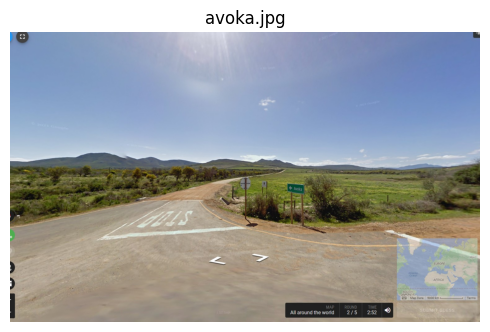

> Raw output: ```json
{"city": "Avoca", "country": "South Africa", "language": "English", "advertising": "", "architecture": "", "landscape": "Open fields, hills in the distance", "vegetation": "Grass, trees", "climate": "Sunny", "road_signs": "Road sign indicating direction to Avoka, stop sign", "traffic_markings": "White lines on the road", "vehicle_details": "", "clothing_type": "", "street_layout": "Two-lane road, dirt road", "cultural_elements": "", "reasoning": "The road sign indicates the location is Avoka, South Africa. The landscape and vegetation are consistent with South Africa."}
```
Geoguesser(city='Avoca', country='South Africa', language='English', advertising='', architecture='', landscape='Open fields, hills in the distance', vegetation='Grass, trees', climate='Sunny', road_signs='Road sign indicating direction to Avoka, stop sign', traffic_markings='White lines on the road', vehicle_details='', clothing_type='', street_layout='Two-lane road, dirt road', cultural_eleme

In [11]:
r1=generate_geoguesser_response(image_folder="image/geoguesser//avoka",model="models/gemini-pro-vision")
pprint(r1)

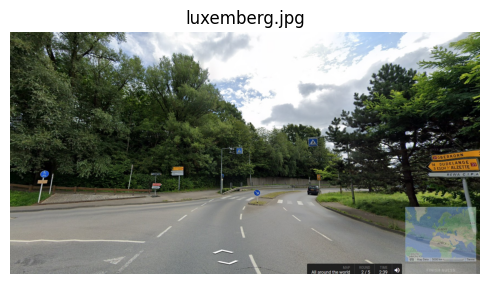

> Raw output:  {
 "city": "Oberkorn",
 "country": "Luxembourg",
 "language": "French",
 "advertising": "Rewa C.I.P.A",
 "architecture": "Modern",
 "landscape": "Urban",
 "vegetation": "Trees",
 "climate": "Temperate",
 "road_signs": "Roundabout, pedestrian crossing, give way",
 "traffic_markings": "Crosswalk",
 "vehicle_details": "Car",
 "clothing_type": "Casual",
 "street_layout": "Roundabout, intersection",
 "cultural_elements": "None",
 "reasoning": "The image shows a roundabout in Oberkorn, Luxembourg. The signs are in French, the architecture is modern, the landscape is urban, the vegetation is trees, the climate is temperate, the road signs are roundabout, pedestrian crossing, give way, the traffic markings are crosswalk, the vehicle details are car, the clothing type is casual, the street layout is roundabout, intersection, the cultural elements are none."
}
city='Oberkorn' country='Luxembourg' language='French' advertising='Rewa C.I.P.A' architecture='Modern' landscape='Urban' 

In [12]:
r2=generate_geoguesser_response(image_folder="image/geoguesser//luxemburg",model="models/gemini-pro-vision")
print(r2)

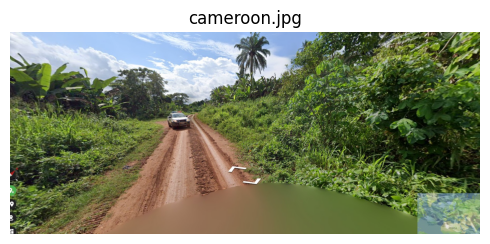

> Raw output: ```json
{"city": "", "country": "Cameroon", "language": "", "advertising": "", "architecture": "", "landscape": "Dense vegetation, dirt road", "vegetation": "Tropical vegetation, palm trees, banana trees", "climate": "Tropical", "road_signs": "", "traffic_markings": "", "vehicle_details": "White pickup truck", "clothing_type": "", "street_layout": "Single lane dirt road", "cultural_elements": "", "reasoning": "The image shows a dirt road surrounded by dense tropical vegetation. The presence of palm trees and banana trees suggests a tropical climate. The image also shows a white pickup truck, which is a common vehicle in Cameroon. The map in the bottom right corner of the image confirms that the location is in Cameroon."}
```
city='' country='Cameroon' language='' advertising='' architecture='' landscape='Dense vegetation, dirt road' vegetation='Tropical vegetation, palm trees, banana trees' climate='Tropical' road_signs='' traffic_markings='' vehicle_details='White pickup

In [14]:
r3=generate_geoguesser_response(image_folder="image/geoguesser//cameroon",model="models/gemini-1.5-flash")
print(r3)

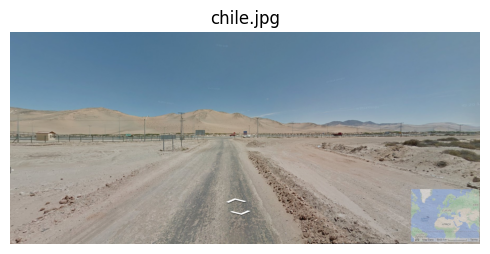

> Raw output:  {
 "city": "Pozo Almonte",
 "country": "Chile",
 "language": "Spanish",
 "advertising": "None",
 "architecture": "Modern",
 "landscape": "Desert",
 "vegetation": "None",
 "climate": "Arid",
 "road_signs": "Spanish",
 "traffic_markings": "None",
 "vehicle_details": "None",
 "clothing_type": "None",
 "street_layout": "None",
 "cultural_elements": "None",
 "reasoning": "The image shows a desert landscape with a road in the foreground. There are mountains in the background. The image is likely taken in a Spanish-speaking country. The architecture is modern. The climate is arid. There are no visible traffic markings. There are no visible cultural elements."
}
city='Pozo Almonte' country='Chile' language='Spanish' advertising='None' architecture='Modern' landscape='Desert' vegetation='None' climate='Arid' road_signs='Spanish' traffic_markings='None' vehicle_details='None' clothing_type='None' street_layout='None' cultural_elements='None' reasoning='The image shows a desert lan

In [16]:
r4=generate_geoguesser_response(image_folder="image/geoguesser//chile",model="models/gemini-pro-vision")
print(r4)

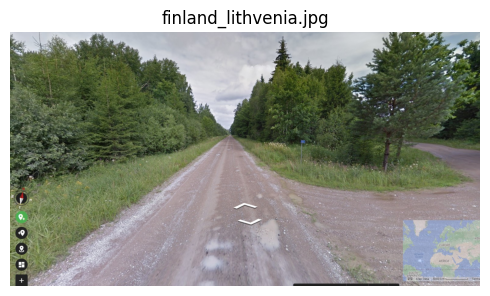

> Raw output:  {
 "city": "",
 "country": "Estonia",
 "language": "",
 "advertising": "",
 "architecture": "",
 "landscape": "Rural",
 "vegetation": "Trees",
 "climate": "",
 "road_signs": "",
 "traffic_markings": "",
 "vehicle_details": "",
 "clothing_type": "",
 "street_layout": "",
 "cultural_elements": "",
 "reasoning": "The image shows a rural road in Estonia. The trees are typical of the region, and the road sign is in Estonian."
}
city='' country='Estonia' language='' advertising='' architecture='' landscape='Rural' vegetation='Trees' climate='' road_signs='' traffic_markings='' vehicle_details='' clothing_type='' street_layout='' cultural_elements='' reasoning='The image shows a rural road in Estonia. The trees are typical of the region, and the road sign is in Estonian.'


In [17]:
r5=generate_geoguesser_response(image_folder="image/geoguesser//lithveniua",model="models/gemini-pro-vision")
print(r5)

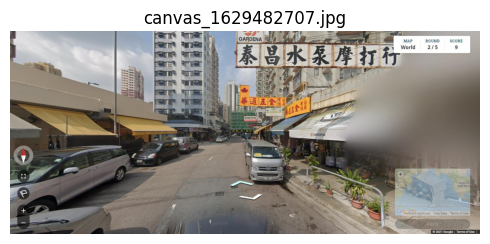

> Raw output:  ```json
{
 "city": "Tsuen Wan",
 "country": "Hong Kong",
 "language": "Cantonese",
 "advertising": "Chinese characters for businesses",
 "architecture": "Chinese style",
 "landscape": "dense urban area",
 "vegetation": "sparse",
 "climate": "humid subtropical",
 "road_signs": "Chinese characters",
 "traffic_markings": "none visible",
 "vehicle_details": "vans and cars",
 "clothing_type": "casual",
 "street_layout": "narrow and crowded",
 "cultural_elements": "Chinese characters",
 "reasoning": "The image shows a street in a dense urban area. The signs are in Chinese characters. The vehicles are mostly vans and cars. The people are wearing casual clothing. The street is narrow and crowded. The climate is humid subtropical."
}
```
city='Tsuen Wan' country='Hong Kong' language='Cantonese' advertising='Chinese characters for businesses' architecture='Chinese style' landscape='dense urban area' vegetation='sparse' climate='humid subtropical' road_signs='Chinese characters' tr

In [21]:
r6=generate_geoguesser_response(image_folder="image/geoguesser//hongkong",model="models/gemini-pro-vision")
print(r6)

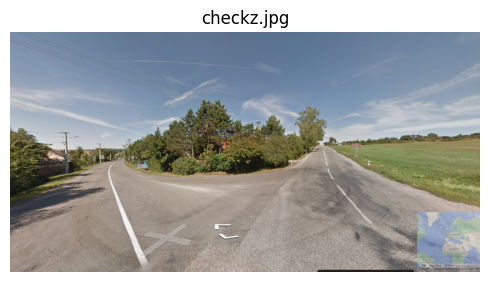

> Raw output:  {
 "city": "Be\u010dkov",
 "country": "Czech Republic",
 "language": "Czech",
 "advertising": "",
 "architecture": "European",
 "landscape": "hilly",
 "vegetation": "deciduous trees",
 "climate": "temperate",
 "road_signs": "Czech road signs",
 "traffic_markings": "white lines",
 "vehicle_details": "sedan, station wagon",
 "clothing_type": "casual",
 "street_layout": "Rural",
 "cultural_elements": "",
 "reasoning": "The image shows a rural intersection in the Czech Republic. The road signs are in Czech, the architecture is European, and the landscape is hilly. The climate is temperate, and the vegetation is deciduous trees. The people in the image are wearing casual clothing. The street layout is rural."
}
city='Bečkov' country='Czech Republic' language='Czech' advertising='' architecture='European' landscape='hilly' vegetation='deciduous trees' climate='temperate' road_signs='Czech road signs' traffic_markings='white lines' vehicle_details='sedan, station wagon' clothin

In [15]:
r7=generate_geoguesser_response(image_folder="image/geoguesser//checkzlovekia",model="models/gemini-pro-vision")
print(r7)

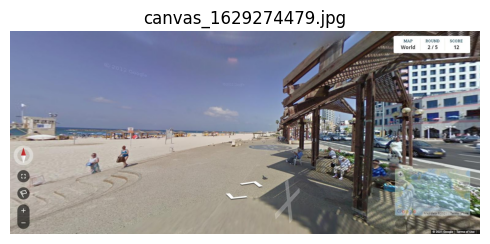

> Raw output:  ```json
{
  "city": "Tel Aviv",
  "country": "Israel",
  "language": "Hebrew",
  "advertising": "None",
  "architecture": "Modern",
  "landscape": "Beach",
  "vegetation": "Palm trees",
  "climate": "Mediterranean",
  "road_signs": "None",
  "traffic_markings": "None",
  "vehicle_details": "Cars",
  "clothing_type": "Beachwear",
  "street_layout": "None",
  "cultural_elements": "None",
  "reasoning": "The image shows a beach with palm trees, people wearing beachwear, and a clear blue sky. The architecture is modern. The image is likely taken in Tel Aviv, Israel."
}
```
city='Tel Aviv' country='Israel' language='Hebrew' advertising='None' architecture='Modern' landscape='Beach' vegetation='Palm trees' climate='Mediterranean' road_signs='None' traffic_markings='None' vehicle_details='Cars' clothing_type='Beachwear' street_layout='None' cultural_elements='None' reasoning='The image shows a beach with palm trees, people wearing beachwear, and a clear blue sky. The architectu

In [22]:
r8=generate_geoguesser_response(image_folder="image/geoguesser//israel",model="models/gemini-pro-vision")
print(r8)

### NOTES: 

Ranking models from geouguessr outputs for few locations:

- 1.gemini-pro-vision
- 2.gemini-1.5-flash
- 3.gemini-1.5-pro

Cost Per Query approx:

- 1.gemini-pro-vision ?
- 2.gemini-1.5-flash: 0.01$ per call
- 3.gemini-1.5-pro : 0.09$ per call


### Let's create another agent which will take the response from Gemini model and custom code contents to generate llist of possible city from it

In [18]:
def get_descritption(r):

    filtered_r = {k: v for k, v in r.dict().items() if v and k not in ['city', 'country']}
    return filtered_r

def geoguessr_expert(model_name,response):

    
    cleaned_response=get_descritption(response)

    geoguessr_expert = """
    You are an expert Geo Guesser.
    You are presented with some descriptions identified from an image.
    Your job is to provide the top 3 cities and their country that match the descriptions.
    Below is the description:
    
    """

    geoguessr_expert += "\n".join([f"{key}: {value}" for key, value in cleaned_response.items()])
    gemini_llm = Gemini(model_name=model_name)
    response=gemini_llm.complete(geoguessr_expert)
    return response

#### Let's try the describer agent from Multimodal agent output for couple of cases

In [19]:
print(geoguessr_expert(model_name="models/gemini-1.5-flash",response=r1))

Based on the provided description, here are the top 3 cities that match:

1. **Avoka, South Africa** - This is the most likely location given the road sign indicating "Avoka". 
2. **Pretoria, South Africa** -  Pretoria is the capital of South Africa and is located in the Gauteng province, known for its open fields and hills. 
3. **Johannesburg, South Africa** - Johannesburg is another major city in South Africa with a similar landscape of open fields and hills. 

**Reasoning:**

The description strongly suggests Avoka, South Africa, due to the road sign. The landscape and vegetation are consistent with South Africa, making Pretoria and Johannesburg plausible alternatives. 



In [20]:
print(geoguessr_expert(model_name="models/gemini-1.5-flash",response=r5))

Based on the description, here are the top 3 cities in Estonia that could potentially match:

1. **Tartu, Estonia:** Tartu is the second-largest city in Estonia and is known for its university and its beautiful, historic center. It's surrounded by rural landscapes with forests and fields, making it a likely location for a rural road.
2. **Pärnu, Estonia:** Pärnu is a popular seaside resort town, but it also has a significant rural hinterland. The surrounding countryside is characterized by forests, meadows, and farmland, making it a possible location for the image.
3. **Rakvere, Estonia:** Rakvere is a smaller city in northern Estonia, known for its medieval castle and its surrounding forests. The region is known for its rural landscapes and its abundance of trees, making it a potential match for the image. 

It's important to note that without the actual image, it's impossible to pinpoint the exact location. However, these three cities are the most likely based on the provided descrip